## Task 2: Regional Temperature Changes

### Preprocessing Data

In [54]:
#imports
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [55]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [56]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [57]:
df_tas_hist=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")

#  assemble a set of models (source_id) for each experiment + variable combination
models_tas_hist  =set(df_tas_hist.source_id)    # all models that have temperature in the historical simulations
models_tas_ssp585=set(df_tas_ssp585.source_id)  # all models that have temperature in the ssp585     simulations

# let's only keep the models that have all the runs (the intersection of the set)
source_set = set.intersection(models_tas_hist, models_tas_ssp585)
source_list=list(source_set)
print(len(models_tas_hist))
print(len(models_tas_ssp585))
print(len(source_list))

55
35
35


In [58]:
source_list.remove('MPI-ESM1-2-LR')
#remove these two models first and then add them in manually with different member_ids
source_list.remove('MPI-ESM1-2-HR')
source_list.remove('AWI-CM-1-1-MR')
print(len(source_list))

32


In [59]:
source_list

['EC-Earth3',
 'NorESM2-MM',
 'FGOALS-f3-L',
 'TaiESM1',
 'CMCC-ESM2',
 'INM-CM5-0',
 'KACE-1-0-G',
 'CESM2-WACCM',
 'ACCESS-ESM1-5',
 'E3SM-1-1',
 'GFDL-CM4',
 'IITM-ESM',
 'INM-CM4-8',
 'ACCESS-CM2',
 'BCC-CSM2-MR',
 'NorESM2-LM',
 'NESM3',
 'CIESM',
 'CAS-ESM2-0',
 'EC-Earth3-Veg-LR',
 'KIOST-ESM',
 'GFDL-ESM4',
 'FIO-ESM-2-0',
 'IPSL-CM6A-LR',
 'CanESM5',
 'MRI-ESM2-0',
 'MIROC6',
 'CAMS-CSM1-0',
 'EC-Earth3-Veg',
 'EC-Earth3-CC',
 'CMCC-CM2-SR5',
 'FGOALS-g3']

In [60]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [61]:
#time index to assign model times to
new_time_index=pd.date_range('1850-01-01', '2099-12-31', freq='ME')
new_time_index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [62]:
#regrid to common 1x1 grid
new_lats=np.arange(-87,88)
new_lons=np.arange(1,359)

### 2.1 Analysis for One Model

In [10]:
#query data
df_tas_hist_canesm5=df.query  ("activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585_canesm5=df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")
#load data
ds_hist_tas_canesm5 = load_zarr_dset(df_tas_hist_canesm5)
ds_ssp585_tas_canesm5 = load_zarr_dset(df_tas_ssp585_canesm5)
#compute diff between avg over years 2089-2099 and 1989-1999
hist_tas_canesm5 = ds_hist_tas_canesm5.sel(time=slice('1989','1999'))
ssp585_tas_canesm5 = ds_ssp585_tas_canesm5.sel(time=slice('2089','2099'))
#dtas = ssp585_tas_canesm5_w_mean.mean('time') - hist_tas_canesm5_w_mean.mean('time') this doesn't work
dtas = ssp585_tas_canesm5.tas.mean('time')-hist_tas_canesm5.tas.mean('time') #i'm not accessing the weights 
dtas

<xarray.DataArray 'tas' (lat: 64, lon: 128)>
dask.array<sub, shape=(64, 128), dtype=float32, chunksize=(64, 128), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

Text(0.5, 1.0, 'CanESM5 TAS Plot')

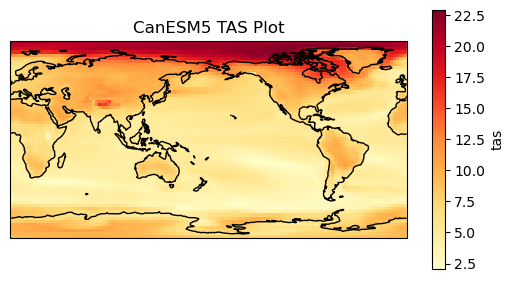

In [12]:
#plot of dtas using cartopy, map of regional warming over the 21st century
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
dtas.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})
ax.set_title('CanESM5 TAS Plot')

### 2.2 Multiple Models

In [14]:
gcm_list = ['KIOST-ESM',
 'CanESM5',
 'EC-Earth3-Veg',
 'CMCC-CM2-SR5',
 'CMCC-ESM2']

In [15]:
#load multiple models
ds_list = list()
for source in gcm_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas'"
                           "& experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas'" 
                           "& experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #compute difference between avg over years 2089-2099 and years 1989-1999
    hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
    ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
    dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
    ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
    ds_interp.assign_coords(model = source) #assign model name as coordinate
    ds_list.append(ds_interp) #append to ensemble of models
gcm_obs = xr.concat(ds_list, dim = 'model', coords = 'minimal',compat='override')
gcm_obs

<xarray.DataArray 'tas' (model: 5, lat: 175, lon: 358)>
dask.array<concatenate, shape=(5, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    height   float64 2.0
Dimensions without coordinates: model

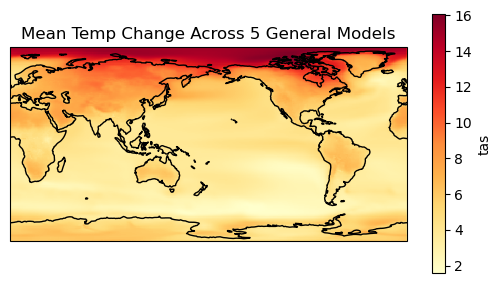

In [16]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
gcm_obs_mean = gcm_obs.mean(dim='model') #took mean across models to eliminate one dimension -> 2D now
gcm_obs_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})
plt.title('Mean Temp Change Across 5 General Models')
plt.show()

### Expand Analysis to All Models

In [63]:
ds_list = list()
for source in source_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas'" 
                           "& experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas'"
                           "& experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #compute difference between avg over years 2089-2099 and years 1989-1999
    hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
    ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
    dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
    ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
    ds_interp= ds_interp.assign_coords(model = source) #assign model name to new model coordinate
    ds_list.append(ds_interp)
ds_all_reg = xr.concat(ds_list, dim = 'model', coords = 'minimal',compat='override')
ds_all_reg

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\codin

<xarray.DataArray 'tas' (model: 32, lat: 175, lon: 358)>
dask.array<concatenate, shape=(32, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U16 'EC-Earth3' 'NorESM2-MM' ... 'FGOALS-g3'

#### Adding More Models

In [64]:
#make a separate list to concat with the ensemble of r1i1p1f1 models
ds_list_2 = list()
#query to individual model
df_hist_tas = df.query(  "source_id == 'CNRM-CM6-1' & member_id == 'r2i1p1f2'" 
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-CM6-1' & member_id == 'r2i1p1f2'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [65]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-G' & member_id == 'r2i1p1f2'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'GISS-E2-1-G' & member_id == 'r2i1p1f2'"
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [66]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1'" 
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [67]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'MCM-UA-1-0'  & member_id == 'r1i1p1f2'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MCM-UA-1-0' & member_id == 'r1i1p1f2'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#rename latitude and longitude to lat/lon for consistency
ds_hist_tas = ds_hist_tas.rename({'latitude': 'lat', 'longitude': 'lon'})
ds_ssp585_tas = ds_ssp585_tas.rename({'latitude': 'lat', 'longitude': 'lon'})
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [68]:
df_hist_tas = df.query(  "source_id == 'MIROC-ES2L'  & member_id == 'r1i1p1f2'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MIROC-ES2L'  & member_id == 'r1i1p1f2'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [69]:
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-H'  & member_id == 'r1i1p1f2'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'GISS-E2-1-H'  & member_id == 'r1i1p1f2'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [70]:
df_hist_tas = df.query(  "source_id == 'CNRM-CM6-1-HR'  & member_id == 'r1i1p1f2'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-CM6-1-HR'  & member_id == 'r1i1p1f2'"
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [71]:
df_hist_tas = df.query(  "source_id == 'UKESM1-0-LL'  & member_id == 'r1i1p1f2'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'UKESM1-0-LL'  & member_id == 'r1i1p1f2'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [72]:
df_hist_tas = df.query(  "source_id == 'HadGEM3-GC31-LL'  & member_id == 'r1i1p1f3'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'HadGEM3-GC31-LL'  & member_id == 'r1i1p1f3'"
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [73]:
df_hist_tas = df.query(  "source_id == 'CESM2'  & member_id == 'r4i1p1f1'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CESM2'  & member_id == 'r4i1p1f1'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [74]:
df_hist_tas = df.query(  "source_id == 'HadGEM3-GC31-MM'  & member_id == 'r1i1p1f3'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'HadGEM3-GC31-MM'  & member_id == 'r1i1p1f3'"
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [75]:
df_hist_tas = df.query(  "source_id == 'CNRM-ESM2-1'  & member_id == 'r2i1p1f2'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-ESM2-1'  & member_id == 'r2i1p1f2'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [76]:
df_hist_tas = df.query(  "source_id == 'MPI-ESM1-2-HR'  & member_id == 'r2i1p1f1'"
                       "& activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MPI-ESM1-2-HR'  & member_id == 'r2i1p1f1'" 
                         "& activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
ds_list_2.append(ds_interp)

In [77]:
ds_13_models = xr.concat(ds_list_2, dim = 'model', coords = 'minimal', compat = 'override')
ds_13_models = ds_13_models.drop_vars('height')
ds_13_models

<xarray.DataArray 'tas' (model: 13, lat: 175, lon: 358)>
dask.array<concatenate, shape=(13, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U15 'CNRM-CM6-1' 'GISS-E2-1-G' ... 'MPI-ESM1-2-HR'

In [78]:
ds_all_45 = xr.concat([ds_13_models, ds_all_reg], dim = 'model', coords = 'minimal', compat = 'override')
ds_all_45 = ds_all_45.drop_vars('height')
ds_all_45

<xarray.DataArray 'tas' (model: 45, lat: 175, lon: 358)>
dask.array<concatenate, shape=(45, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U16 'CNRM-CM6-1' 'GISS-E2-1-G' ... 'FGOALS-g3'

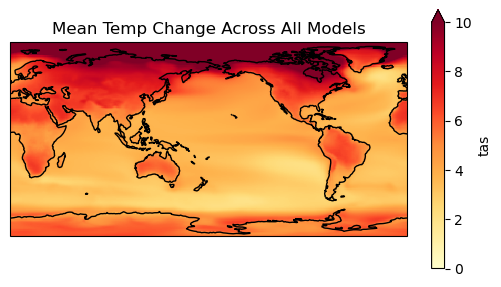

In [79]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_all_reg_mean = ds_all_45.mean(dim='model') #took mean across models
img = ds_all_reg_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), vmin = 0, vmax = 10, cbar_kwargs = {"shrink": 0.7})
img.colorbar.set_ticks(np.arange(0,12,2))
plt.title('Mean Temp Change Across All Models')
plt.show()

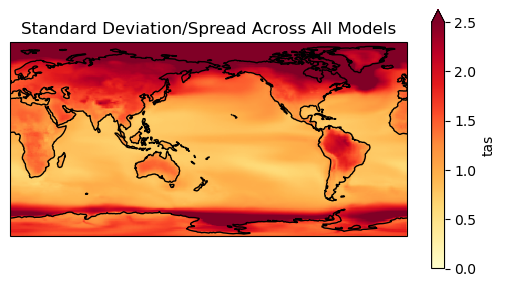

In [80]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_all_reg_std = ds_all_45.std(dim='model') #took mean across models
img = ds_all_reg_std.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), vmin=0, vmax=2.5, cbar_kwargs = {"shrink": 0.7})
img.colorbar.set_ticks([0, 0.5, 1.0, 1.5, 2.0, 2.5]) #adjust ticks 
plt.title('Standard Deviation/Spread Across All Models')
plt.show()

In [81]:
#saving to netcdf file
ds_all_45.to_netcdf("CMP6_processed_tas_regional_ssp585_data_2025-04-03.nc", mode = 'w', format = "NETCDF4", engine = 'netcdf4')